In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras

In [ ]:
# mounting from google drive
from google.colab import drive
drive.mount("/content/drive", force_remount= True)


Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Synthetic_mobile_txn.csv")

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# this data is imbalanced and highly scaled
print("max amount", data["amount"].max())
print("min amount", data["amount"].min())

max amount 92445516.64
min amount 0.0


In [ ]:
ML_df = data[data["isFraud"] == 1]
NoML_df = data[data["isFraud"] == 0]

print("percentage of identified Money Laundered Transactions: ", 100*(len(ML_df)/len(data)))
print("percentage of NOT Money Laundered Transactions: ", 100*(len(NoML_df)/len(data)))

percentage of identified Money Laundered Transactions:  0.12908204481801522
percentage of NOT Money Laundered Transactions:  99.87091795518198


In [ ]:
# imbalance data set

### **Data Visualization**

<Axes: >

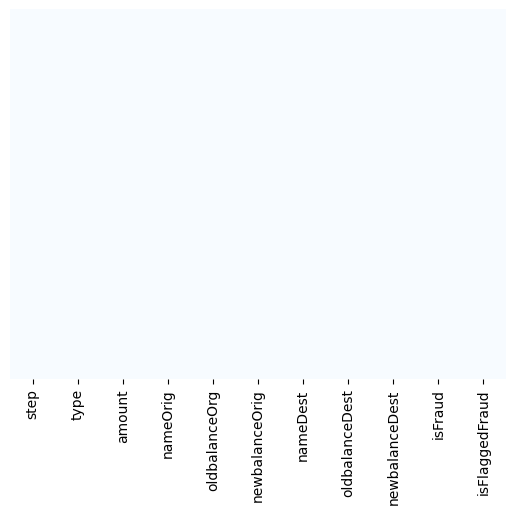

In [ ]:
# Let's check if we have any missing data
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = "Blues")

In [ ]:
# check if there's relationship between types of transaction and money laundering transaction
data["type"].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


<Axes: xlabel='type', ylabel='count'>

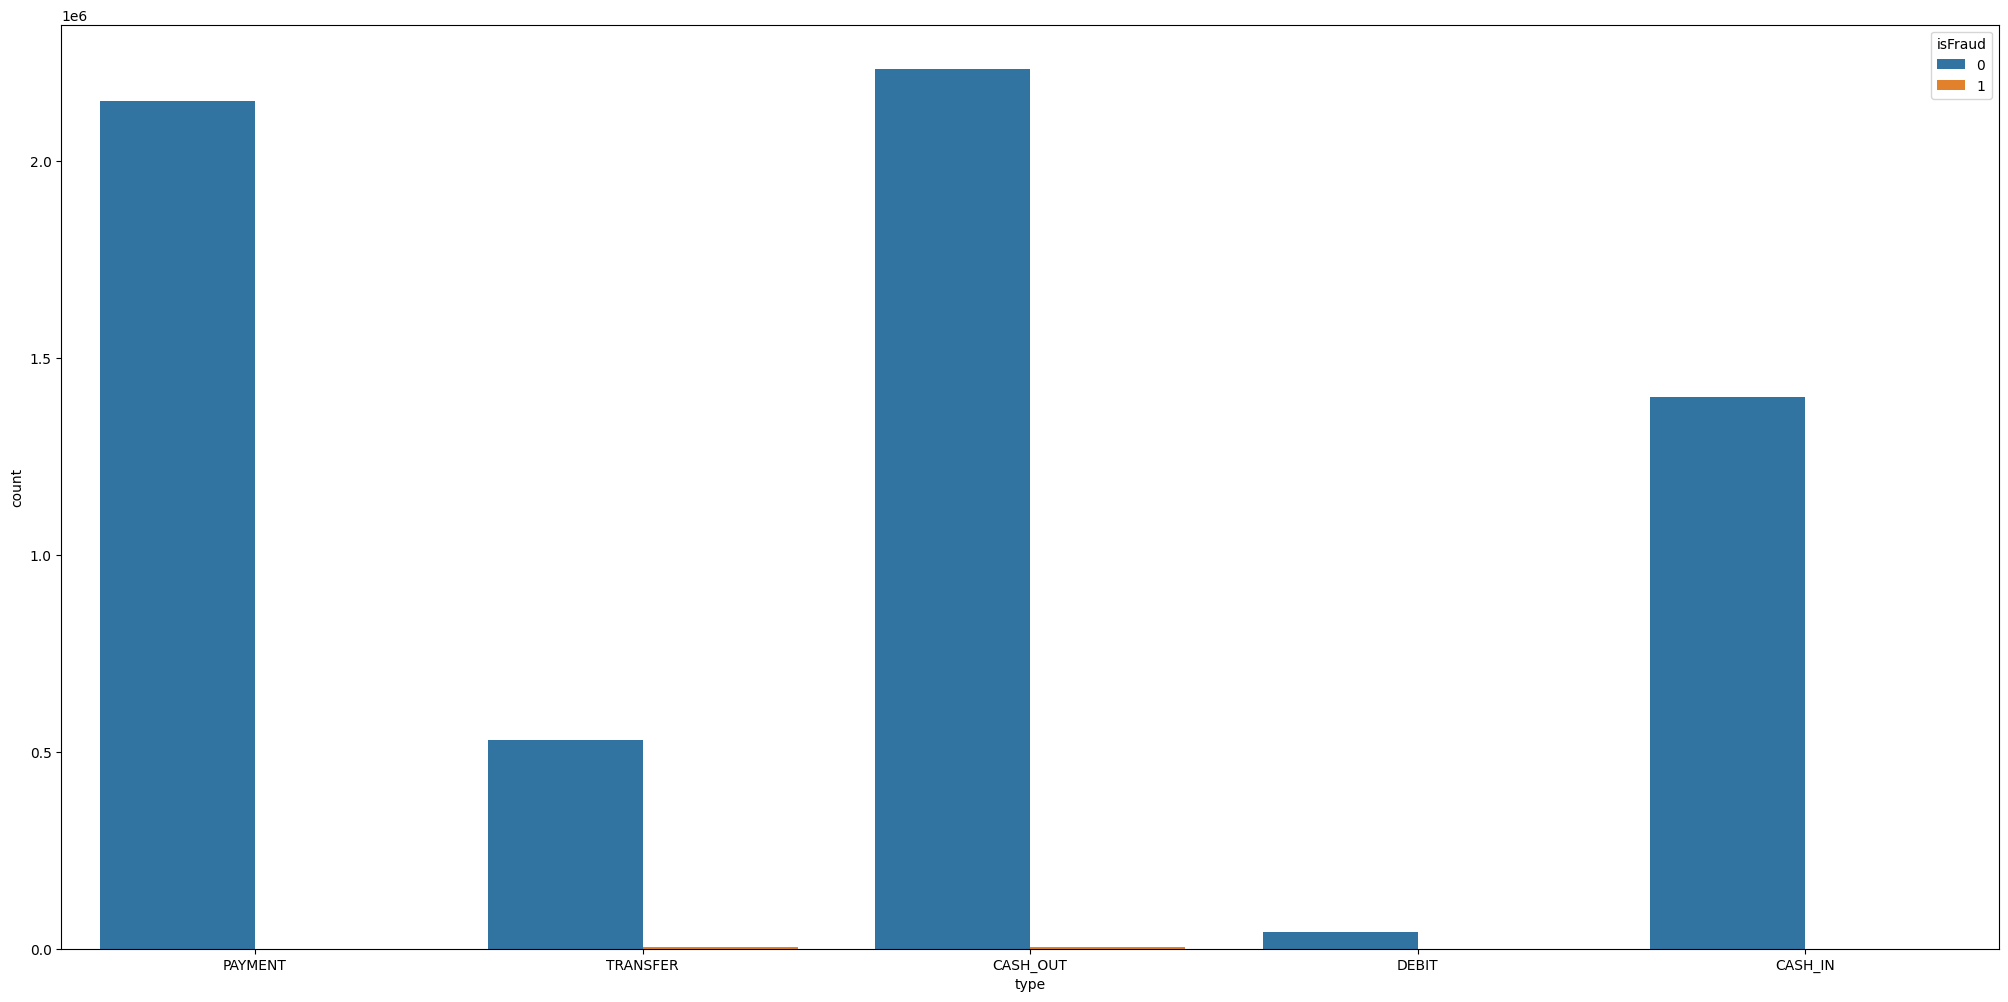

In [ ]:
plt.figure(figsize = [25, 12])
sns.countplot(x = "type", hue = "isFraud", data = data)

/tmp/ipython-input-2542786269.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ML_df["amount"], label = "Money Laundered Txn", shade = True, color = "r")
/tmp/ipython-input-2542786269.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(NoML_df["amount"], label = "Not Money Laundered Txn", shade = True, color = "b")


Text(0.5, 0, 'Money Laundering in comparision to amount')

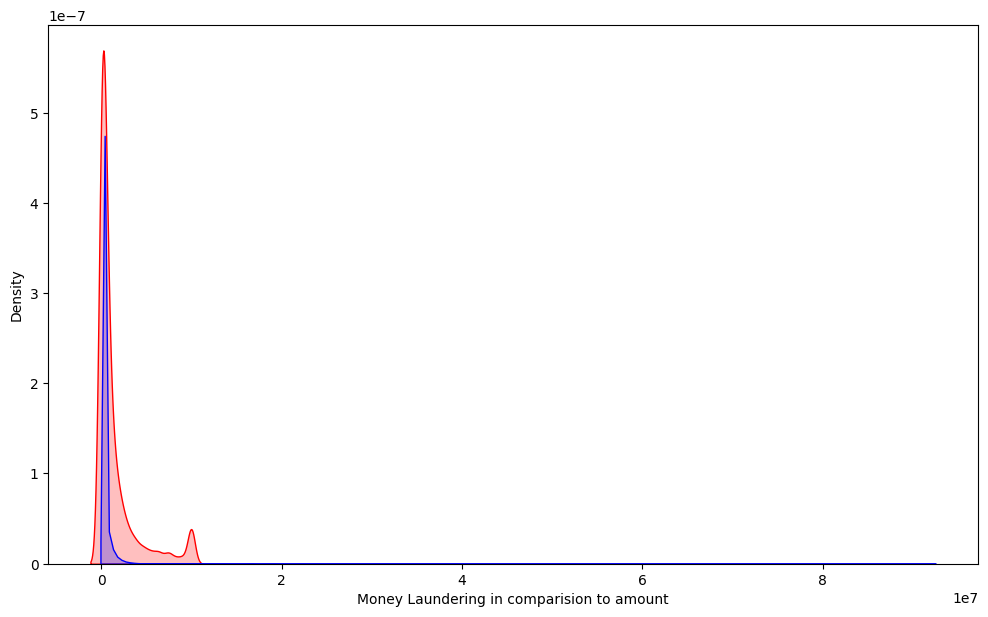

In [ ]:
plt.figure(figsize = (12, 7))

sns.kdeplot(ML_df["amount"], label = "Money Laundered Txn", shade = True, color = "r")
sns.kdeplot(NoML_df["amount"], label = "Not Money Laundered Txn", shade = True, color = "b")

plt.xlabel("Money Laundering in comparision to amount")

### **Preprocessing Data**

In [ ]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
col_names = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
features = data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [ ]:
# One Hot Encoding
data_extract = data[["type", "isFraud"]]

type_dummies = pd.get_dummies(data_extract["type"], drop_first = True)
data_extract.drop(["type"], axis = 1, inplace = True)
new_data = pd.concat([data_extract, type_dummies, scaled_features], axis = 1, ignore_index = False)
new_data.head()

/tmp/ipython-input-3384268242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_extract.drop(["type"], axis = 1, inplace = True)


,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,False,False,True,False,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411
1,0,False,False,True,False,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411
2,1,False,False,False,True,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411
3,1,True,False,False,False,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411
4,0,False,False,True,False,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411


<Axes: >

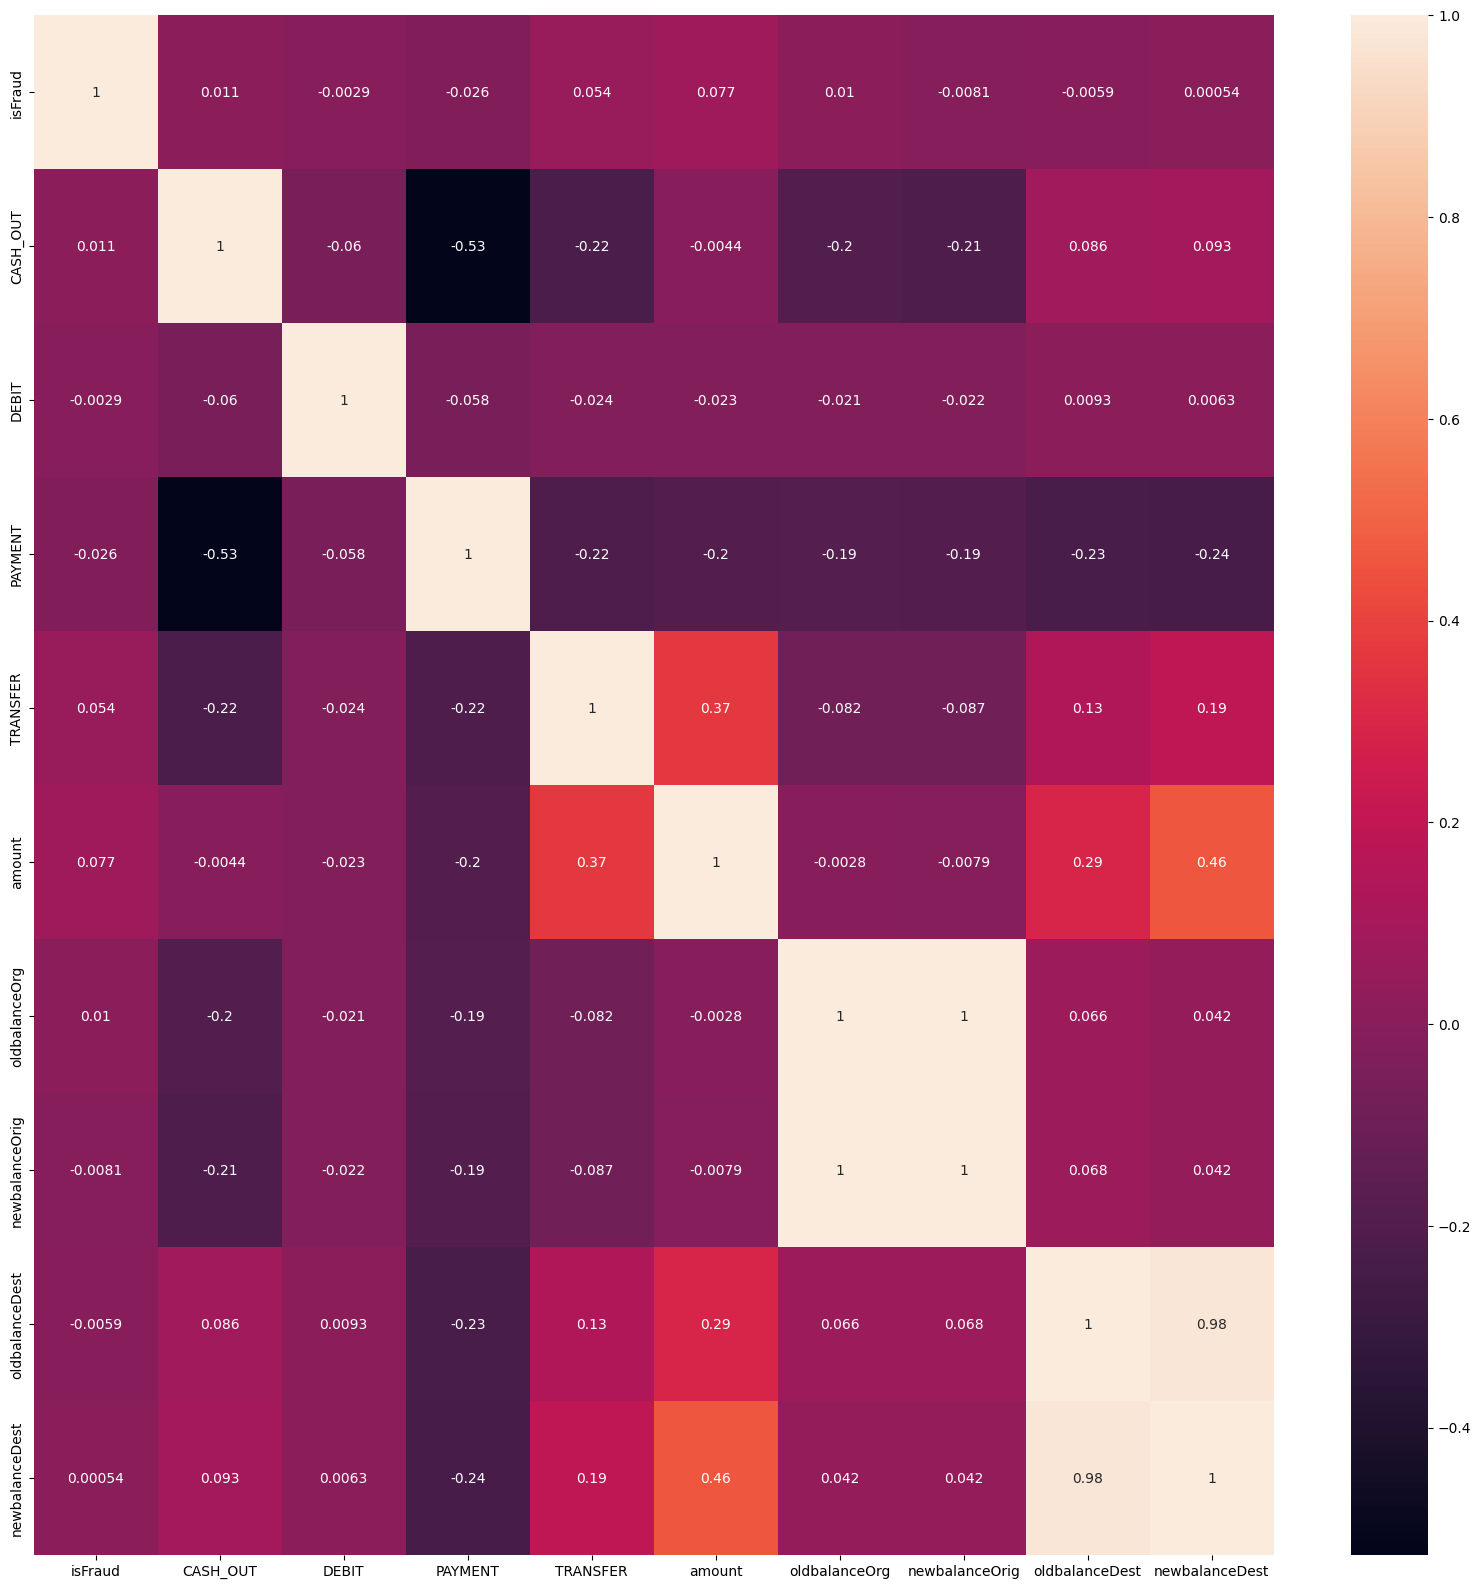

In [ ]:
correlations = new_data.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)


### **Training and Deployment of ML Model**

In [ ]:
x = new_data.iloc[:, new_data.columns != "isFraud"]
y = new_data.iloc[:, new_data.columns == "isFraud"]

In [ ]:
# split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)


#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train.values.ravel()) # ravel flattens an array into one dimension
y_pred = decision_tree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.89      0.89      0.89      2419

    accuracy                           1.00   1908786
   macro avg       0.95      0.94      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



In [ ]:
# Oversample and retrain the model
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(x, y)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size = 0.3, random_state = 0)
print("After oversampling, X has shape: ", X_res.shape)
print("After oversampling, y has shape: ", y_res.shape)

After oversampling, X has shape:  (12708814, 9)
After oversampling, y has shape:  (12708814, 1)


In [ ]:
decision_tree.fit(X_train_res, y_train_res.values.ravel())
y_pred_res = decision_tree.predict(X_test_res)
print(classification_report(y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1905975
           1       1.00      1.00      1.00   1906670

    accuracy                           1.00   3812645
   macro avg       1.00      1.00      1.00   3812645
weighted avg       1.00      1.00      1.00   3812645



### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train.values.ravel())
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.95      0.79      0.86      2419

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



In [ ]:
# Use the oversampling dataste
random_forest.fit(X_train_res, y_train_res.values.ravel())
y_pred_res = random_forest.predict(X_test_res)
print(classification_report(y_test_res, y_pred_res))